In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageDraw
import random
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\JSH\Desktop\MyGithub\paper_implementation\.paper_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from SSD.model import SSD
model = SSD()

In [16]:
import json
from SSD.dataset import SSD_Dataset
import albumentations as A
from albumentations.pytorch import transforms as A_transforms
with open('../.data/train_ann.json','r') as f:
    json_file = json.load(f)

transform = A.Compose([
    A.Resize(300,300),
    # A.RandomCrop(width=400, height=400),
    A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=(30,40),p=1),
    A.Normalize(mean=0.5, std=0.5),
    # A_transforms.ToTensorV2()
], bbox_params=A.BboxParams(format='coco', min_visibility=0.2 ,label_fields=['labels']))

SSD_dataset = SSD_Dataset(json_file,transform=transform)
train_loader = torch.utils.data.DataLoader(SSD_dataset, batch_size=4,shuffle=False, collate_fn=SSD_dataset.collate_fn, num_workers=1)


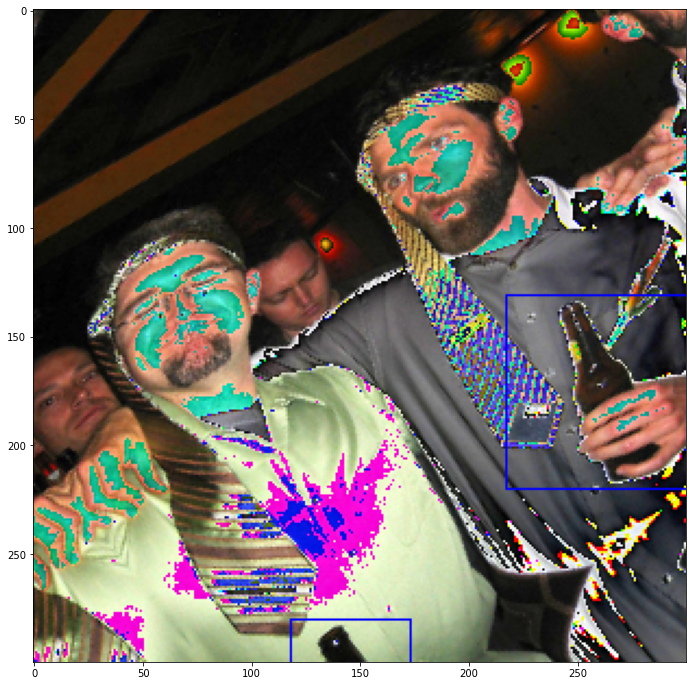

In [25]:
n = random.randint(1,1000)
image,boxes,label = SSD_dataset[n]
to_pil = transforms.ToPILImage()
img = to_pil(image).convert('RGB')
draw = ImageDraw.Draw(img)
fig , ax = plt.subplots(1,1,figsize = (12,12))
for i,box in enumerate(boxes):
    x1,y1,x2,y2 = box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2
    draw.rectangle((x1,y1,x2,y2),outline=(0,0,255), width=1)

plt.imshow(img)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from SSD.loss import SSD_Loss
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
# momentum = 0.9
weight_decay = 0.0005
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = SSD_Loss()
model = model.to(device)

epochs = 20
for epoch in tqdm(range(epochs)):
    for images,bboxes,labels in tqdm(train_loader):
        images = images.to(device)
        bboxes = [box.to(device) for box in bboxes]
        labels = [label.to(device) for label in labels]
        optimizer.zero_grad()

        pred_bboxs,pred_labels = model(images)
        
        loss = criterion(pred_bboxs, pred_labels, bboxes, labels)
        loss.backward()
        optimizer.step()


